## Define Imports

In [13]:
import torch
import torchvision
import torchaudio
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics
from tqdm import tqdm

import os
import sys
import random
import time
import copy
import logging
import bisect
import json
import shutil
import IPython.display as ipd
from torchtoolbox.tools import mixup_data, mixup_criterion
from torch.nn.functional import cross_entropy
import timm

## Define Config Parameters

In [14]:
class Config():
    def __init__(self) -> None:

        self.run_environment = 'local' # 'kaggle' 'local' 'colab'

        # Device
        if (self.run_environment == 'kaggle') or (self.run_environment == 'colab'):
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        
        # Dataset Path
        if self.run_environment == 'kaggle':
            self.dataset_swiss_birds_test = ''
            self.dataset_swiss_birds_test_metadata = ''
        elif self.run_environment == 'local':
            self.dataset_swiss_birds_test = '/home/colin/elec5305/ele5305_research_project/swiss_birds/wav_files/test'
            self.dataset_swiss_birds_test_metadata = '/home/colin/elec5305/ele5305_research_project/swiss_birds/metadata_test.csv'

        # Out path
        if self.run_environment == 'kaggle':
            self.outpath = '/kaggle/working/results'
        elif self.run_environment == 'local':
            self.outpath = 'results'
        elif self.run_environment == 'colab':
            self.outpath = ''


        # Dataloader options
        self.num_workers = 2
        self.test_batch_size = 4

        # Model name
        self.model_name = 'tf_efficientnet_b0.ns_jft_in1k'
        # Pretrained
        if self.run_environment == 'kaggle':
            self.pretrained_weights = '/kaggle/input/weights12/model_weights.pth'
        elif self.run_environment == 'local':
            self.pretrained_weights = '/home/colin/elec5305/ele5305_research_project/src_swiss_birds/results/long_run_no_resampling/model_weights.pth'
            self.pretrained_weights_ = '/home/colin/elec5305/ele5305_research_project/src_swiss_birds/results/long_run_no_resampling/training_prog.json'
            self.pretrained_weights__ = '/home/colin/elec5305/ele5305_research_project/src_swiss_birds/results/long_run_no_resampling/'

        # Image Transforms
        self.test_transforms = torchvision.transforms.Compose([
                    torchaudio.transforms.AmplitudeToDB(),
                    torchvision.transforms.Resize(size=[128,312], antialias=True),
                    ])

       
        # Audio Transforms
        # self.train_transforms_audio = torchvision.transforms.Compose([
        #     torchvision.transforms.RandomChoice([torchvision.transforms.RandomApply([
        #                                                                             torchaudio.transforms.PitchShift(sample_rate=32000, n_steps=4),
        #                                                                             torchaudio.transforms.FrequencyMasking(freq_mask_param=80),
        #                                                                             ], 
        #                                                                             p=0.7)]), 
        #                                                                         ])
        
        self.test_transforms_audio = None


        # Audio Features
        self.sample_rate = 32000
        self.period = 5

        # Mel Spectrogram Parameters
        self.n_fft=2048
        self.f_min=40
        self.f_max=15000
        self.hop_length=512
        self.n_mels=128
        self.mel_args = {'n_fft': self.n_fft,
                         'f_min': self.f_min,
                         'f_max': self.f_max,
                         'hop_length': self.hop_length,
                         'n_mels': self.n_mels}
        
        self.species_list = ['Song Thrush', 'Common Chaffinch', 'European Robin', 'Yellowhammer', 'Eurasian Wren', 'Common Nightingale', "Western Bonelli's Warbler", 'Common Redstart', 'Red Crossbill', 'Garden Warbler', 'Black Redstart', 'Tree Pipit', 'Marsh Warbler', 'Great Spotted Woodpecker', 'Tawny Owl', 'Common Blackbird', 'Willow Tit', 'Eurasian Eagle-Owl', 'Great Tit', 'Eurasian Blackcap', 'Common Chiffchaff', 'Eurasian Coot', 'Eurasian Reed Warbler', 'Yellow-legged Gull', 'Coal Tit']
        
CONFIG = Config()

## Define Test Set Class

In [15]:
class SwissBirds_TestSet(torch.nn.Module):
    def __init__(self, datapath, metadata_df, audio_transforms, sample_rate, period, inherited_species_list, *args, **kwargs) -> None:
        super().__init__()

        # Default values
        self.sample_rate = sample_rate
        self.audio_transforms = audio_transforms
        self.period = period


        self.df = metadata_df
        self.datapath = datapath
       
        self.species = inherited_species_list

        self.make_cumulative_list()

        return
    
    def make_cumulative_list(self):

        length_list_seconds = np.array(list(self.df['length']))
        num_clips_per_recording = (length_list_seconds // self.period).astype(int)
        num_clips_per_recording = num_clips_per_recording.tolist()
        for i in range(len(num_clips_per_recording)):
            if num_clips_per_recording[i] == 0:
                num_clips_per_recording[i] = 1
        cum_list = [0] * len(num_clips_per_recording)
        cumulative_sum = 0

        for i,num in enumerate(num_clips_per_recording):
            cumulative_sum += num
            cum_list[i] = cumulative_sum

        self.df['cum_num_clips'] = cum_list
        self.df['num_clips'] = num_clips_per_recording

        return

    def __len__(self):
        length = self.df['cum_num_clips'].iloc[-1]
        return length


    def __getitem__(self, idx_glob):

        # Get pd idx
        idx = bisect.bisect_left(self.df['cum_num_clips'], idx_glob + 1)

        # Get local idx
        if idx != 0:
            loc_idx = idx_glob - self.df['cum_num_clips'].iloc[idx - 1]
        else:
            loc_idx = idx_glob

        # Get row in df
        dict_idx = dict(self.df.iloc[idx])

        # Get labels as torch tensors
        primary_label = torch.tensor([1 if dict_idx['en'] == label else 0 for label in self.species],dtype=float)

        # Load audio
        ogg_file = os.path.join(self.datapath,dict(self.df.iloc[idx])['filename'])
        waveform, sample_rate = torchaudio.load(ogg_file)
        waveform = waveform.ravel()

        # Get clip of length self.period
        target_audio_length = sample_rate * self.period
        current_audio_length = len(waveform)
        if current_audio_length >= target_audio_length:
            start = loc_idx * target_audio_length
            waveform_seg = waveform[start:start+target_audio_length]
        else:
            padding_length = target_audio_length - current_audio_length
            waveform_seg = torch.nn.functional.pad(waveform, (0, padding_length), 'constant', 0)

        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.sample_rate)
        waveform_seg = resampler(waveform_seg)

        # Apply transform
        if self.audio_transforms is not None:
            waveform_seg = self.audio_transforms(waveform_seg.unsqueeze(0)).ravel()

        return waveform_seg, primary_label

## Create Test Loader Instance

In [16]:
test_df = pd.read_csv(CONFIG.dataset_swiss_birds_test_metadata)
test_dataset = SwissBirds_TestSet(datapath=CONFIG.dataset_swiss_birds_test, metadata_df=test_df, audio_transforms=CONFIG.test_transforms_audio, sample_rate=CONFIG.sample_rate, period=CONFIG.period, inherited_species_list=CONFIG.species_list)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,num_workers=CONFIG.num_workers, batch_size=CONFIG.test_batch_size, shuffle = False, pin_memory = True)


## Define Model

In [17]:
class MelSpectrogramLayer(nn.Module):
    def __init__(self, sample_rate, n_fft, hop_length, n_mels, transform):
        super(MelSpectrogramLayer, self).__init__()
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )
        self.transform = transform

    def forward(self, waveform):

        mel_spectrogram = self.mel_transform(waveform)

        batched = True
        if mel_spectrogram.dim() == 2:
            batched = False
        elif mel_spectrogram.dim() == 3:
            batched = True

        if batched == True:
            if self.training and torch.rand(1) >= CONFIG.masking_prob and CONFIG.masking == True:
                mel_spectrogram = torchaudio.transforms.FrequencyMasking(
                    freq_mask_param=mel_spectrogram.shape[1] // 5
                )(mel_spectrogram)
                mel_spectrogram = torchaudio.transforms.TimeMasking(
                    time_mask_param=mel_spectrogram.shape[2] // 5
                )(mel_spectrogram)
        else:
            if self.training and torch.rand(1) >= CONFIG.masking_prob and CONFIG.masking == True:
                mel_spectrogram = torchaudio.transforms.FrequencyMasking(
                    freq_mask_param=mel_spectrogram.shape[0] // 5
                )(mel_spectrogram)
                mel_spectrogram = torchaudio.transforms.TimeMasking(
                    time_mask_param=mel_spectrogram.shape[1] // 5
                )(mel_spectrogram)


        if batched == True:
            mel_spectrogram = mel_spectrogram.unsqueeze(1)
            mel_spectrogram = mel_spectrogram.expand(-1, 3, -1, -1)
        else:
            mel_spectrogram = mel_spectrogram.unsqueeze(0)
            mel_spectrogram = mel_spectrogram.expand(3, -1, -1)

        mel_spectrogram = self.transform(mel_spectrogram)

        mel_spectrogram = torch.nan_to_num(mel_spectrogram)

        mel_spectrogram = self.normalize(mel_spectrogram)
        
        return mel_spectrogram
    
    def normalize(self, image):
        mel_spectrogram = (image - image.min()) / ( image.max() - image.min())
        return mel_spectrogram

    

# https://www.kaggle.com/code/leonshangguan/faster-eb0-sed-model-inference

def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()


def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.
    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    output = torch.nn.functional.interpolate(
        framewise_output.unsqueeze(1),
        size=(frames_num, framewise_output.size(2)),
        align_corners=True,
        mode="bilinear").squeeze(1)

    return output

class AttBlockV2(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

class Mel_Classifier(torch.nn.Module):
    def __init__(
        self, 
        model_name: str,
        mel_generator: MelSpectrogramLayer,
        # config=None,
        pretrained=True, 
        num_classes=25, 
        in_channels=3
    ):
        super().__init__()
        
        self.mel_generator = mel_generator

        base_model = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            num_classes=0,
            global_pool="",
            in_chans=in_channels,
        )
        
        layers = list(base_model.children())[:-2]
        self.backbone = nn.Sequential(*layers)

        in_features = base_model.num_features

        self.fc1 = nn.Linear(in_features, in_features, bias=True)
        self.att_block = AttBlockV2(
            in_features, num_classes, activation="linear")

        self.init_weight()

    def init_weight(self):
        # init_bn(self.bn0)
        init_layer(self.fc1)
        
    def forward(self, input_data):
        input_data = self.mel_generator(input_data)

        x = input_data

        x = self.backbone(x)
        
        # Aggregate in frequency axis
        x = torch.mean(x, dim=2)

        x1 = torch.nn.functional.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = torch.nn.functional.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = x.transpose(1, 2)
        x = torch.nn.functional.relu_(self.fc1(x))
        x = x.transpose(1, 2)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)

        output_dict = {
            "clipwise_output": clipwise_output,
        }

        # return output_dict
        return clipwise_output

In [18]:
def get_model(config):
    melspec_layer = MelSpectrogramLayer(sample_rate=config.sample_rate,
                                    n_fft=config.n_fft,
                                    hop_length=config.hop_length,
                                    n_mels=config.n_mels,
                                    transform=config.test_transforms)
    network = Mel_Classifier(model_name=config.model_name,
                            mel_generator=melspec_layer)
    
    print('Load PreTrained Weigths')
    network.load_state_dict(torch.load(config.pretrained_weights, map_location=config.device))
    
    return network

In [19]:
network = get_model(CONFIG)

Load PreTrained Weigths


## Evaluation Metric

In [20]:
def padded_cmap(solution, submission, padding_factor=5):
    solution = solution.drop(['row_id'], axis=1, errors='ignore')
    submission = submission.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

## Run Test Set

In [21]:
toProb = torch.nn.Softmax(dim=1)

correct = 0
predictions_array = np.zeros((len(test_dataloader.dataset), len(test_dataloader.dataset.species)), dtype=float)
solutions_array = np.zeros((len(test_dataloader.dataset), len(test_dataloader.dataset.species)), dtype=float)
network.eval()
# for i,data in enumerate(test_dataloader):
with tqdm(enumerate(test_dataloader, 0), total=len(test_dataloader), desc="Test Set") as val_pbar:
        for i, data in val_pbar:

            if CONFIG.device == 'cuda':
                inputs, labels = data[0].to(CONFIG.device), data[1].to(CONFIG.device)
            else:
                inputs, labels = data[0], data[1]
                    
            outputs = network(inputs)

            # Get model output and label to array
            curr_predictions_array = toProb(outputs).detach().cpu().numpy()
            predictions_array[i*test_dataloader.batch_size:(i+1)*test_dataloader.batch_size,:] = curr_predictions_array
            hardlabels = labels.detach().cpu().numpy()
            hardlabels[hardlabels < 0.99] = 0
            curr_solutions_array = hardlabels
            solutions_array[i*test_dataloader.batch_size:(i+1)*test_dataloader.batch_size,:] = curr_solutions_array

            # Update progress bar
            correct += (outputs.argmax(1) == labels.argmax(1)).sum().item()

# Get cMAP
cmap_5 = padded_cmap(solution=pd.DataFrame(solutions_array), submission=pd.DataFrame(predictions_array), padding_factor=5)

# Get Accuracy
test_accuracy = 100 * correct / len(test_dataloader.dataset)

print('cmap_5 value is {}'.format(cmap_5))
print('Test Accuracy is {}'.format(test_accuracy))

# Save results
result_dict = {'test_accuracy': test_accuracy, 
               'cmap_5': cmap_5}
outputName = 'results.json'
jsonpath = os.path.join(CONFIG.pretrained_weights__, outputName)
with open(jsonpath, 'w') as json_file:
    json.dump(str(result_dict), json_file)

Test Set:   0%|          | 0/246 [00:00<?, ?it/s]

Test Set: 100%|██████████| 246/246 [01:15<00:00,  3.25it/s]


cmap_5 value is 0.5691748001925636
Test Accuracy is 37.90650406504065


## Analysis

In [22]:
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sn

def plot_data(file_path: Path, savePath):

    with open(file_path, 'r') as json_file:
        data = json.load(json_file)

    validation_accuracy, validation_loss, training_accuracy, training_loss = data['validation_accuracy'], data['validation_loss'], data['training_accuracy'], data['training_loss']
    epochs = range(1, len(validation_accuracy) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 7))

    ax1.plot(epochs, training_loss, label="Training")
    ax1.plot(epochs, validation_loss, label="Validation")
    ax1.set_title("Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss [-]")
    ax1.grid("on")
    ax1.legend()

    ax2.plot(epochs, training_accuracy, label="Training")
    ax2.plot(epochs, validation_accuracy, label="Validation")
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy [%]")
    ax2.grid("on")
    ax2.legend()

    # plt.tight_layout()

    plt.savefig(savePath, dpi=600,  bbox_inches='tight')
    plt.show()

# https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
def getConfusionMatrix(y_pred, y_true, name):
    
    # constant for classes
    classes = CONFIG.species_list

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes])
    
    plt.figure(figsize = (12,8))
    sn.heatmap(df_cm, annot=True)
    plt.savefig(name, bbox_inches = 'tight', dpi=600)

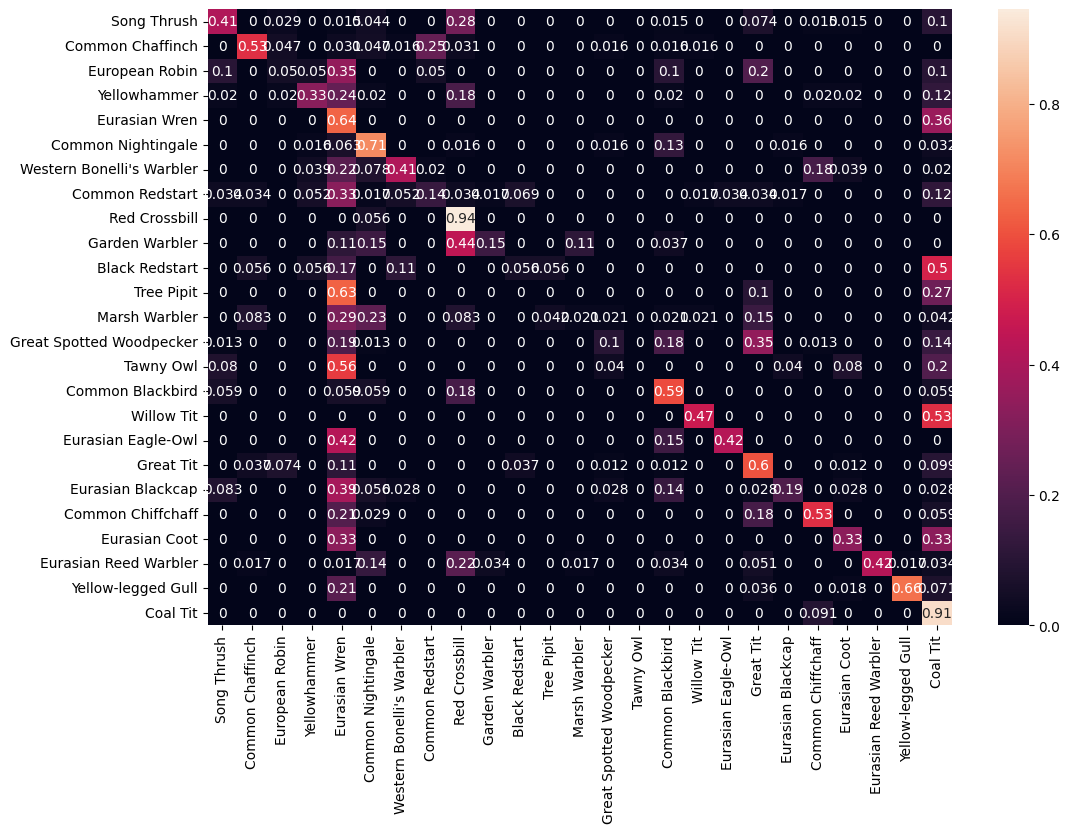

In [23]:
y_pred = predictions_array.argmax(1)
y_true = solutions_array.argmax(1)

getConfusionMatrix(y_pred=y_pred,y_true=y_true, name='confusion_matrix.png')

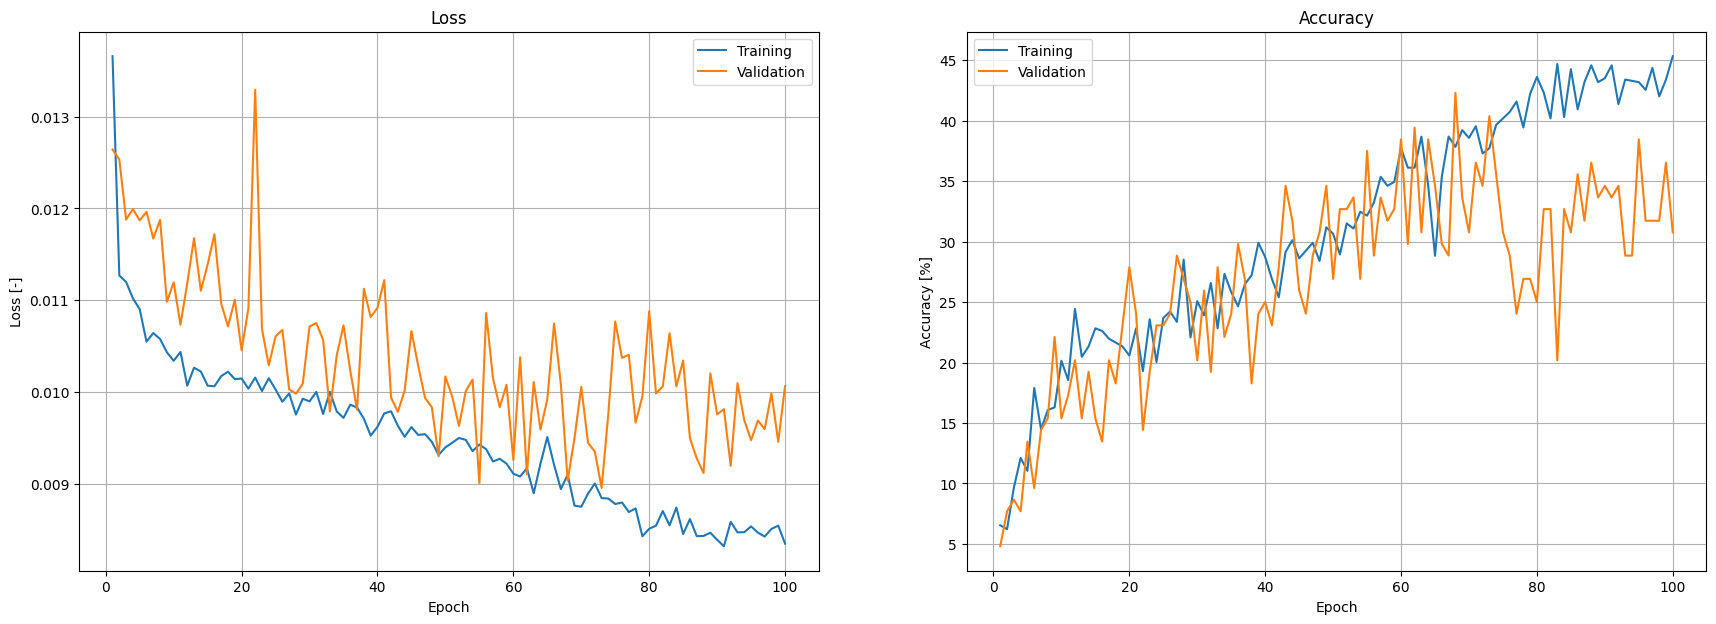

In [24]:
plot_data(file_path=CONFIG.pretrained_weights_, savePath=CONFIG.pretrained_weights__)